# Project 3: Domain Data Preparation
This project will help you familiarize with common data collection and preprocessing tasks. We will mine public text data related to the topic of coronavirus from different sources, and process and combine them to a single corpus, on which we can perform feature engineering to prepare for subsequent analyses.

In [1]:
# Run this cell to complete all the environment setups on Colab
# You do not need to upload anything else to your Colab environment after running this cell
# This cell has been tagged with excluded_from_script, it will be ignored by the autograder

# download and extract handout to current dir
!rm -rf p3_handout
!mkdir p3_handout
!wget -qc http://clouddatascience.blob.core.windows.net/m20-foundation-data-science/p3-domain-data-preparation/colab/p3_handout_v4.tgz -O - | tar -xz -C p3_handout
!rm -f p3_handout/*.ipynb
!mv p3_handout/* .

# install relevant packages
!pip install -r requirements.txt

# install chromedriver
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver .

     |████████████████████████████████| 20.2MB 1.3MB/s 
     |████████████████████████████████| 10.0MB 37.1MB/s 
     |████████████████████████████████| 1.4MB 38.4MB/s 
     |████████████████████████████████| 122kB 42.2MB/s 
     |████████████████████████████████| 911kB 43.8MB/s 
     |████████████████████████████████| 5.6MB 22.4MB/s 
     |████████████████████████████████| 13.7MB 31.4MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp36-none-any.whl size=1434673 sha256=05190dc6f8e396446bfb867ef38d3ee203d6dd56d2bda8c481f2023dd36d769a
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built nltk
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninst

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:13 http://archive.ubuntu.com/ubun

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import collections
import time
import re
import string
import os
import argparse
from datetime import datetime

import nltk
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import wordnet

import bs4
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.common import exceptions

from pdfminer import high_level

In [2]:
# this cell has been tagged with excluded_from_script
# it will not be run by the autograder
%matplotlib inline

## Part A: Text Processing

Text data on the internet is very messy.  Typically there is a fair amount of processing work to do once you have collected any sizeable chunk of text data, in order to have it ready for subsequent analyses. To get you familiar with this kind of data, this section will walk you through some common processing tasks:

The first step is to import the lemmatizer and set of English stopwords from `nltk`:

In [3]:
nltk.download("stopwords", quiet = True)
nltk.download("wordnet", quiet = True)
nltk.download("punkt", quiet = True)
nltk.download('averaged_perceptron_tagger', quiet = True)
lemmatizer = WordNetLemmatizer()
english_stopwords = set(nltk.corpus.stopwords.words('english'))

### Question 1: Text cleaning and tokenization
Now implement the function `preprocess_text` which, given a text string, returns a processed list of tokens, where each token:
1. is in lower case
1. appears in the same order as in the input string.
1. is in its lemmatized form, if one exists. If a word cannot be lemmatized, do not include it in the output.
1. does not contain any characters other than letters and digits:
   * remove trailing `'s`: `Children's` becomes `children`
   * omit other apostrophes: `don't` becomes `dont`
   * break tokens at other punctuation and non-ascii characters: `word-of-mouth` becomes `["word", "of", "mouth"]`.
1. is not a stopword (after lemmatization)
1. contains at least two characters (after lemmatization)

**Notes**:
* To detect punctuation and non-ascii characters, you can use `string.punctuation` and `string.ascii_letters` respectively.
* When lemmatizing a word, you should also specify the part-of-speech `pos` parameter. This can be obtained by calling `nltk.pos_tag()` and using the first returned tag (in case there are multiple possibilities). You can interpret the returned tag as follows:
    * If it starts with "J", it is an adjective.
    * If it starts with "V", it is a verb.
    * If it starts with "R", it is an adverb.
    * Otherwise, it is a noun.
* Different order of operations like removing punctuation, tokenization and lemmatization will yield different results. 

In [4]:
def preprocess_text(text, stopwords = {}):
    """
    Process the input text and turn it into a list of cleaned, lemmatized words
    
    args:
        text (str) : the input text
    
    kwargs:
        stopwords (Set[str]) : the set of stopwords to exclude
    
    return:
        List[str] : the list of tokenized words from the input text
    """

    def pos_conversion(tokenized_text):
      '''
      Convert nltk.pos_tag result to lemmatizer.lemmatize.pos input
      args:
          tokenized_text (list of str) : e.g., ['Today', 'is', 'a', 'good', 'day']      
      return:
        str : str with each word been properly lemmatized with a pos
      '''
      # Call pos_tag on each word individually as required in this case and generate list of tuples
      pos_tag_results = [nltk.pos_tag([token])[0] for token in tokenized_text]
      # Transformation of pos tags
      new_pos_tag_results = []
      for element in pos_tag_results:
        key, value = element
        if value.startswith("J"):
          new_pos_tag_results.append((key, "a"))
        elif value.startswith("V"):
          new_pos_tag_results.append((key, "v"))
        elif value.startswith("R"):
          new_pos_tag_results.append((key, "r"))
        else:
          new_pos_tag_results.append((key, "n"))
      # Lemmatize based on individual tags
      return " ".join(lemmatizer.lemmatize(element[0], pos = element[1]) for element in new_pos_tag_results)

    # Lowercase the string
    text = text.lower()
    # Remove trailing 's
    text = re.sub("\'s", "", text)
    # Omit other apostrophes
    text = re.sub("\'", "", text)
    # break tokens at other punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), " ", text)
    # break tokens at non-ascii characters
    text = re.sub('[^%s]' % re.escape(string.ascii_letters + '0123456789'), " ", text)
    # Lemmatization (the order about where to put this is very important!)
    text = pos_conversion(nltk.word_tokenize(text))
    # Remove stopwords
    text = " ".join([word for word in text.split(" ") if word not in stopwords])
    # Each token contains at least two characters
    text = " ".join([word for word in text.split(" ") if len(word) > 1])
    return text.split(" ") if text.split(" ") != [''] else []

In [5]:
def test_preprocess_text():
    # lowercase
    assert preprocess_text("I like Data Science") == ['like', 'data', 'science']
    
    # tokenization
    assert preprocess_text(" ab..ab. .ab . ab.")== ['ab', 'ab', 'ab', 'ab']
    assert preprocess_text("word-of-mouth hello-world")== ['word', 'of', 'mouth', 'hello', 'world']
    assert preprocess_text("you've")== ['youve']
    assert preprocess_text("gotta")== ['get', 'ta']
    assert preprocess_text("hello_world") == ["hello", "world"]
    
    # apostrophe handling
    assert preprocess_text("She's")== ['she']
    assert preprocess_text("car, cars, car's, cars'")== ['car', 'car', 'car', 'car']
    
    # lemmatizer
    assert preprocess_text("cats") == ['cat']
    assert preprocess_text("DID") == ['do']
    
    # part-of-speech
    assert preprocess_text("CMU is Cool") == ['cmu', 'be', 'cool']
    
    # unicode handling
    assert preprocess_text("hope this👏will work") == ['hope', 'this', 'will', 'work']
    
    # stopwords
    assert preprocess_text("the weather is really nice", english_stopwords) == ['weather', 'really', 'nice']
    assert preprocess_text(
        "To apply SVM learning in partial discharge classification, data input is very important!?",
        english_stopwords
    ) =='apply svm learn partial discharge classification data input important'.split()
    assert preprocess_text("after all he's done", english_stopwords) == []
    assert preprocess_text("they didn’t have much chance of guessing what it was without further clues.", english_stopwords) == ['much', 'chance', 'guess', 'without', 'far', 'clue']
    
    # additional from piazza
    assert preprocess_text("hello_world") == ["hello", "world"]
    assert preprocess_text("DUQUE'S", english_stopwords) == ["duque"]
    assert preprocess_text( "'shed'") == ['hed']
    assert preprocess_text("'fake news'") == ['fake', 'news']
    assert preprocess_text("the 'rona", english_stopwords) == ['rona']
    # test on long text string
    with open("local_test_refs/henrys_letter.txt") as infile, open("local_test_refs/processed_henrys_letter.txt") as outfile:
        processed_str = preprocess_text(infile.read())
        reference_str = outfile.read().splitlines()
        assert processed_str == reference_str
    print("All tests passed!")

test_preprocess_text()

All tests passed!


You may notice that the lemmatization functionality isn't perfect; for example, it would map `"as"` to `"a"` because `"as"` is being treated as a noun instead of a proposition (with tag `"IN"`). In general, identifying the correct part-of-speech tag is very context-dependent (for example, "clear" can be either an adjvective, adverb, verb or noun). In the context of this project, we will not dive deep into these linguistic nuances, and settle with the lemmatization rules above.

The above processing function already covers a fair number of text cleaning tasks. We can now begin to collect data from online sources.

## Part B: Tweet Mining

Twitter is among the most popular social media; according to [Omnicore](https://www.omnicoreagency.com/twitter-statistics/#:~:text=There%20are%2048.35%20million%20monthly,monetizable%20daily%20active%20Twitter%20users.), it has 48.35 million active users, 42% of whom use Twitter on a daily basis. Furthermore, tweets are public by default, making the site a particularly rich data source on any given trending topic.

In this section, you will extract tweets related to the topic of coronavirus. It should be noted that, due to the dynamic nature of Twitter, any user can edit or remove their old tweets, making it difficult to obtain deterministic results (and to autograde your code). Therefore, we will instead use a fixed Tweet [dataset from Kaggle](https://www.kaggle.com/smid80/coronavirus-covid19-tweets) and provide you with a custom API to query tweets from this dataset. For your own data science projects in the future, however, you are encouraged to explore the [official Twitter API](https://developer.twitter.com/en/docs).

### Question 2: Retrieve starting tweets
Implement the function `get_tweets` that sends a GET request to https://gettweets.azurewebsites.net/11637/tweets and returns the status code as well as the response JSON. The response JSON is a list of dictionaries, each corresponding to one tweet and having the following format:

```python
{
    'text': 'hello world', # str, the tweet content
    'lang': 'en', # str, the tweet language
    'id': 123, # int, the tweet id
    'time': '2019-12-04' # # str, yyyy-mm-dd
}
```

**Notes**:
* The API endpoint url https://gettweets.azurewebsites.net/11637/tweets is provided in the global variable `TWEET_API`.
* You should call `.text` on the response object to retrieve its content.

In [6]:
TWEET_API = "https://gettweets.azurewebsites.net/11637/tweets"

def get_tweets(url = TWEET_API):
    """
    Retrieve tweets by sending a GET request to the provided API endpoint.
    
    params:
        url (str) : the url to send request to
    
    return:
        Tuple(status_code, response):
            status_code (int) : the status code of the request
            response (List[Dict[str, str]]) : the JSON response, which is a list of dictionaries,
                one for each tweet
    """
    response = requests.get(TWEET_API)
    return response.status_code, response.text

In [7]:
def test_get_tweets():
    response_code, tweets = get_tweets()
    assert response_code == 200
    tweet_jsons = json.loads(tweets)
    assert len(tweet_jsons) == 100
    first10_tweet_ids = [tweet_json["id"] for tweet_json in tweet_jsons[:10]]
    assert first10_tweet_ids == [2819, 3075, 3331, 3587, 3843, 4099, 4355, 4611, 4867, 5123]
    assert tweet_jsons[1]["text"] == 'Los Angeles County has identified 6 new cases of the coronavirus &amp; declared a local state of emergency.\n#CoronavirusOutbreak #Coronavirusflorida #LosAngeles'
    print("All tests passed!")

test_get_tweets()

All tests passed!


Great, you now have 100 tweets at your disposal! Typically though, we would like to have more flexibility in our search, for example by specifying particular parameters that indicate our search objective. In this case, our API provides four parameters as follows:

* `lang` - specify the tweet language, which is an [ISO 639-1 code](https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes), e.g., `en` for English.
* `start` - the start date, formatted as yyyy-mm-dd; only tweets created on or after this date are returned.
* `end` - the end date, formatted as yyyy-mm-dd; only tweets created on or before this date are returned.
* `page` - the tweet page number.

Note the use of the `page` parameter here. Because returning a large JSON would put burden on the server, we have restricted all response JSONs to only include 100 tweets. To get more tweets that also satisfy your search query, you can specify the `page` parameter based on the following formula: if `page = i` (indexed from 1) then the tweets from index `100*(i-1) + 1` to index `100*i` (inclusive) will be returned.

As an example, if your configuration of `(lang, start, end)` yields 306 tweets, then:

* `page = 1` or no `page` specified will return the tweets 1-100.
* `page = 2` will return the tweets 101-200.
* `page = 3` will return the tweets 201-300.
* `page = 4` will return the tweets 301-306.
* `page = 5` or larger will return a JSON with empty content `"[]"`.

### Question 3: Search for tweets with parameters
Implement the function `get_tweet_texts_with_params` that sends a GET request to the provided API endpoint with (optional) input parameters `lang`, `start`, `end` and `page`. This function should collect all tweets that satisfy the search query if the number of such tweets is smaller than 10000, or the first 10000 tweets otherwise.

In [8]:
def get_tweet_texts_with_params(url = TWEET_API, lang = "all", start = "na", end = "na", n_tweets = 10000):
    """
    Search for tweets with parameters and extract their text content
    
    kwargs:
        url (str) : the url to send request to
        lang (str) : the tweet language in ISO 639-1 format
        start (str) : the start date, yyyy-mm-dd
        end (str) : the end date, yyyy-mm-dd
        n_tweets (int) : the number of tweets to collect
    
    return:
        List[str] : a list with the contents of the first n_tweets tweets returned from the search
    """
    tweet_jsons = []
    for i in range(int(n_tweets/100)):
      response = requests.get(TWEET_API, params={'page': i+1, 'lang': lang, 'start': start, 'end': end})
      tweet_jsons += json.loads(response.text)
    return [x['text'] for x in tweet_jsons]

In [9]:
def test_get_tweet_texts_with_params():
    tweet_texts = get_tweet_texts_with_params(lang = "en", start = "2020-03-09", end = "2020-03-09")
    assert len(tweet_texts) == 10000
    example_tweets = [
        '#coronavirus #COVID19 2 new cases reported in Kentucky (Harrison Co and Fayette Co), bring the states total to 6.',
        "#BREAKING\n#Italy is extending its #coronavirus #quarantine measures, which include a ban on public gatherings, to the ENTIRE COUNTRY.\nItaly's coronavirus death toll jumped on Monday by 97 to 463. \nIt is the worst-hit country after #China.\nhttps://t.co/Q6MNtyXttA\n#COVID19",
        '#Investorsâ€™ fortunes plunge as sell pressure hit banking stocks amid COVID-19 fear https://t.co/stihfvM7xZ via @MarketForcesA\n\n@Afrinvest @nsenigeria #equitymarket #fmcg #banks #insurance #oilandgas #COVID19',
        'FROM A DOCTOR IN ITALY...\n#coronavirus\n#Coronavirusflorida\n#CoronaVirusUpdates\n#CoronavirusUSA\n#COVID19 \n#covid19Canada\n#COVID19Toronto\n#CoronaVirusCanada \n#coronavirusToronto https://t.co/ZelZHWTuR1',
        'Ina joint statement, Major League Baseball, Major League Soccer, the National Basketball Association, and the National Hockey League announced they are limiting locker room access due to concerns about the Coronavirus pandemic. #MLB #MLS #NBA #NHL #COVID19 #coronavirus https://t.co/Z6CUqxDrAO',
        'Coronaviruses (CoV) are a large family of viruses that cause illness ranging from the common cold to more severe diseases such asMERS-CoVand SARS-CoV. A novel coronavirus (nCoV) is a new strain that has not been previously identified in humans.  #coronavirus #CoronavirusOutbreak',
        'Simon Coveny and the entire Irish government attitude towards #covid19 just got destroyed on  #cblive',
        'The reason for the toilet paper shortage is because when one person sneezes, 100 people shit themselves ðŸ¤§ #coronavirus #COVID19 #tolietpaper',
        'Latest #COVID19 numbers in Missouri - https://t.co/27vLQ3ZmqY',
        'Tips on battling #CoronaVirusUpdate #COVID2019 #CoronavirusOutbreak \nhttps://t.co/UaY8boPzHg'
    ]
    
    assert tweet_texts[800:810] == example_tweets
    emoji_tweet = "Be carefull guy's and wish you all happy holi to you &amp; your family. :) \n#HappyHoli #CoronavirusOutbreak #à¤¹à¥‹à¤²à¥€ #à¤¹à¥‹à¤²à¤¿à¤•à¤¾_à¤¦à¤¹à¤¨ #BankLooteriBJP #Coronavid19 #marketcrash  #reliance #colours #KurkureWithSidNaaz #MondayMorning #MereAngneMein ##RangBarseWithSid #à¤¬à¥�à¤°à¤¾_à¤¨_à¤®à¤¾à¤¨à¥‹_à¤¹à¥‹à¤²à¥€_à¤¹à¥ˆ https://t.co/Rg2SpMNKZD"
    assert emoji_tweet in tweet_texts
    print("All tests passed!")
    
test_get_tweet_texts_with_params()

All tests passed!


### Question 4: Process tweet data
Looking at some of the tweets above, we see that:
1. Some tweets contain shortened URLs, for example `https://t.co/DzhsXPxUDa`. These are always in the form of `http://t.co/` or `https://t.co/` followed by 10 alphanumeric characters. These links should be removed.
1. Some tweets contain emoticons such as `:)` or `<3`. The characters in these emoticons should be removed.

Implement the function `process_tweet` that take as input a tweet text. This function will perform the above two cleaning steps and then call `preprocess_text` on the cleaned tweet.

**Notes**:
* We have provided a list of emoticons for you in the variable `emoticons`. You can assume that only elements in this set are considered emoticons and need to be removed.
* Note that there may be no space between a shortened URL and the next word. However, you can assume that there are always 10 alphanumeric characters after http://t.co/ or https://t.co/.
* Remember to specify the stopwords parameter `english_stopwords` when calling `preprocess_text`.
* Side note: one of the inventors of emoticons is [Professor Scott Fahlman](https://www.cs.cmu.edu/~sef/sefSmiley.htm) in our own LTI.

In [10]:
emoticons = [
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)', '<3',
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', 'b=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
]


def process_tweet(tweet_text):
    """
    Process and tokenize tweets, in addition to removing URLs and emoticons
    
    args:
        tweet_text (str) : a list of tweet contents
    
    return:
        List[str] :  a list of processed tokens from the input tweet
    """
    text = re.sub("(?:https|http)\:\/\/t\.co\/(\w){10}", " ", tweet_text)
    for emot in emoticons:
      text = text.replace(emot, " ")
    return preprocess_text(text, stopwords=english_stopwords)


# do not modify this function
def process_tweet_data(tweet_texts):
    return [process_tweet(tweet_text) for tweet_text in tweet_texts]

In [11]:
def test_process_tweet():
    assert process_tweet("It's a great day :D") == ['great', 'day']
    assert process_tweet("<3hello") == ["hello"]
    assert process_tweet("goodX-Dday") == ["good", "day"]
    assert process_tweet("http://t.co/WJs5bmRthU,http://t.co/WJs5bmRthU,") == []
    assert process_tweet("hellohttp://t.co/WJs5bmRthUworld") == ["hello", "world"]
    assert process_tweet("http://taco/WJs5bmRthU") == ['http', 'taco', 'wjs5bmrthu']
    print("All tests passed!")
    
test_process_tweet()

All tests passed!


## Part C: Web Scraping

We now move to the second method of data extraction: using Selenium and Beautifulsoup to parse HTML codes. More speficically, we will collect news articles related to the same topic of Coronavirus from two major media outlets -- [Nature](https://www.nature.com/) and [The New York Times](https://www.nytimes.com/). Through this exercise, you will learn how to navigate HTML structures from different webpages in order to get the desired information.

To begin, we have provided you with three helper functions:

1. `retrieve_url` takes as input a webpage string URL and creates a BeautifulSoup object from the corresponding page content.
1. `init_chromedriver` initializes the Selenium webdriver used with Chrome. If you specify `debug = True`, a new browser window will show up every time the function is called, allowing you to inspect the webpage and the effect of your Selenium code. Note that this only works if you are running Jupyter notebook locally; it does not work on Google Colab.
1. `init_geckodriver` functions similarly and is used with Firefox.

See the [Data Collection and Extraction Primer](https://nbviewer.jupyter.org/url/clouddatascience.blob.core.windows.net/m20-foundation-data-science/p3-data-collection-extraction-primer/data_collection_extraction_primer.ipynb) for detailed installation instructions. Our grader supports both the Chromium browser (version `83.0.4103.61-0ubuntu0.18.04.1`) and Firefox browser (version `77.0.1+build1-0ubuntu0.18.04.1`), so you can pick either `init` function to use in this assignment.

**Notes**:
* When you submit your code, remember to set `debug = False` in all of your function calls to `init_chromdriver` or `init_geckodriver`.
* If you use chromedriver, edit the `PATH_TO_CHROMEDRIVER` variable to point to where the file is on your system. Similarly, if you use geckodriver, edit the variable `PATH_TO_GECKODRIVER`.

In [12]:
def retrieve_url(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    return soup

# path to the chromedriver executable, edit this if you use chromedriver locally
# if you are on Colab, do not change this path
# if you are on Windows, you may need to add .exe to the end of the path
PATH_TO_CHROMEDRIVER = "./chromedriver"

# path to the geckodriver executable, edit this if you use geckodriver locally
# if you are on Windows, you may need to add .exe to the end of the path
PATH_TO_GECKODRIVER = "./geckodriver"

# do not modify this function
def init_chromedriver(debug = False):
    options = webdriver.ChromeOptions()
    if not debug:
        options.add_argument('--headless')
        options.add_argument('--no-sandbox')
        options.add_argument("--disable-setuid-sandbox")
        options.add_argument('--user-agent=""Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.157 Safari/537.36""')
    return webdriver.Chrome(executable_path = PATH_TO_CHROMEDRIVER, options = options)

# do not modify this function
def init_geckodriver(debug = False):
    options = webdriver.FirefoxOptions()
    if not debug:
        options.add_argument('--headless')
        options.add_argument('--no-sandbox')
        options.add_argument("--disable-setuid-sandbox")
        options.add_argument('--user-agent=""Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.157 Safari/537.36""')
    return webdriver.Firefox(executable_path = PATH_TO_GECKODRIVER, options = options)

### Question 5: Parsing a single article from Nature
Implement the function `parse_page_nature` that takes as input a Nature news article string URL and return a JSON dictionary with the following format:

```python
{
    'Title': 'When will the coronavirus outbreak peak?' #str
    'Author': ['David Cyranoski'] # list, a list of author names in the same order as they appear on the page
    'Published Date': '2020-04-21' # str, yyyy-mm-dd
    'Summary': '.....' #str, the summary div between the title and author fields, or empty string if no summary is available
    'Content': '.....' #list, the whole article content, where every element is a paragraph (i.e., comes from a <p> tag)
}
```

The values of `Summary` and `Content` should be raw texts that do not contain any HTML tag. For example, if the input HTML code is `"<p><b>Hello</b><a href="https://google.com">World</a><p>"` then the output should be `"Hello World"`.

In the local test we have provided the full reference JSON files of the given article pages for you. If your dictionary does not match the reference JSON, you should print out both and do a careful comparison to see where the difference is.

**Notes**:
* Occasionally there are some "Related" blocks embedded in the article text (example [here](http://clouddatascience.blob.core.windows.net/m20-foundation-data-science/p3-domain-data-preparation/nature_related.png)). These are characterized by the `aside` HTML tag and should not be included.
* The `Published Date` field should be the original article date, not the updated date. For example, the `Published Date` for [this article](https://www.nature.com/articles/d41586-020-00166-6) is 2020-01-22.
* Remember to call `strip()` on all values in the returned dictionary so that there is no leading or trailing space anywhere. If a content paragraph becomes empty after `strip()`, it should not be included. You do not need to call any other text processing task in section A.

In [13]:
def parse_page_nature(url):
    """
    Parse a single New York Times article at the given URL
    
    args:
        url (str) : the article URL
    
    return:
        Dict[str, str] : the parsed information stored in JSON format, which includes:
            Title, Author, Published Date, Summary and Content
    """
    soup = retrieve_url(url)
    for x in soup.select('aside'):
      x.extract()
    parsed_page = {}
    parsed_page['Title'] = soup.select("h1.article-item__title")[0].get_text().strip()
    parsed_page['Author'] = [author.get_text().strip().replace(" &", "") for author in soup.select("h3.sans-serif.strong.tab.tab-skin.ma0")]
    parsed_page['Published Date'] = datetime.strptime(soup.select("time", itemprop="datePublished")[0].get_text(), '%d %B %Y').strftime("%Y-%m-%d")
    parsed_page['Summary'] = soup.select("div.article-item__teaser-text")[0].get_text().strip()
    parsed_page['Content'] = [element.get_text().strip() for element in soup.select("div.article__body p") if (element.get_text() != "\n" and element.get_text().strip())]
    return parsed_page


In [14]:
def test_parse_page_nature():
    nature1 = parse_page_nature("https://www.nature.com/articles/d41586-020-00190-6")
    nature1_reference = json.load(open("local_test_refs/nature1.txt"))
    assert nature1 == nature1_reference
    nature2 = parse_page_nature("https://www.nature.com/articles/d41586-020-00166-6")
    nature2_reference = json.load(open("local_test_refs/nature2.txt"))
    assert nature2 == nature2_reference
    nature3 = parse_page_nature("https://www.nature.com/articles/d41586-020-00798-8")
    nature3_reference = json.load(open("local_test_refs/nature3.txt"))
    assert nature3 == nature3_reference
    print("All tests passed!")

test_parse_page_nature()

All tests passed!


### Question 6: Parsing several Nature articles from a search page
Now that you have successfully parsed individual article pages, the next step is to search for all the relevant articles and parse each of them. More specifically, we want to search for articles that:
1. contain the term "coronavirus" (case-insensitive) *in their titles*
1. do not contain any of the terms "Daily briefing", "Podcast" or "Backchat" (case-insensitive) in their titles
1. were published in a given period of time (e.g., February 01, 2020 to March 01, 2020 inclusive)
1. have "News" as the Article type and belong to the journal "Nature" -- these criteria can be specified in the search result page.

Explore the [Nature search page](https://www.nature.com/search) and [Advanced search page](https://www.nature.com/search/advanced) to see how you may obtain the search results that satisfy the above conditions. Then implement the function `extract_nature_articles` that returns a list of JSON-like dictionaries, each resulting from calling `parse_page_nature` on one article in the search results.

**Notes**:
* The article dictionaries should be ordered based on their associated dates **on the search result page**, from earlier to later. If two articles have the same date, order them alphabetically based on their titles.
* If you see a connection reset error message, your code is sending requests too fast. You can include a `time.sleep` for a short duration between requests to avoid this issue.
* Don't use datetime.fromisoformat since it's only available from Python 3.7

In [15]:
def extract_nature_articles(start_date, end_date, base_url = "https://www.nature.com"):
    """
    Search for and parse all coronavirus-related News article from the Nature journal that were
    published in a given period
    
    args:
        start_date (str): the lower bound of the date range to filter articles,
            has the format yyyy-mm-dd
        end_date (str): the upper bound (inclusive) of the date range to filter articles,
            has the format yyyy-mm-dd
    
    return:
        List[Dict[str, str]] : a list of parsed JSON for each articles returned by
            the search query
    """
    from operator import itemgetter
    # Get new url from manual experiment
    keyword = "coronavirus"
    journal = "nature"
    article_type = "news"
    base_url = "https://www.nature.com"
    url = base_url + "/search?title={0}&order=date_asc&journal={1}&article_type={2}".format(keyword, journal, article_type) # date sorted
    num_pages = int(retrieve_url(url).select("li.inline-group-item.inline-group-middle")[-2].get_text().strip().replace("page ", ""))

    # Iterate through pages
    results = []
    reach_max_date = False
    for page_number in range(1, num_pages+1):
      current_url = url + "&page={0}".format(page_number)
      soup = retrieve_url(current_url)
      if reach_max_date:
        break
      # Retrieve a list of docs in this page
      for article in soup.select('h2 a', href=True):
        json = parse_page_nature(base_url + article['href'])
        article_time = datetime.strptime(json["Published Date"], "%Y-%m-%d") 
        title = json["Title"].lower()
        # filter conditions: 
        # do not contain any of the terms "Daily briefing", "Podcast" or "Backchat" (case-insensitive) in their titles
        # start and end date
        if article_time > datetime.strptime(end_date, "%Y-%m-%d"):
          reach_max_date = True
          break
        if "Daily briefing".lower() in title or "Podcast".lower() in title or "Backchat".lower() in title:
          continue
        if article_time < datetime.strptime(start_date, "%Y-%m-%d"):
          continue
        results.append(json)
    # same date rank alphabetically
    return sorted(results, key=itemgetter('Published Date', 'Title'))


In [16]:
def test_extract_nature_articles():
    parsed_articles = extract_nature_articles("2020-02-01", "2020-03-01")
    expected_titles = [
        'HIV vaccine failure, coronavirus papers and an unprecedented glimpse of the Sun',
        'Did pangolins spread the China coronavirus to people?',
        'How scientists are fighting the novel coronavirus: A three minute guide',
        'CRISPR enhancement, coronavirus source and a controversial appointment',
        'Scientists fear coronavirus spread in countries least able to contain it',
        'More than 80 clinical trials launch to test coronavirus treatments',
        'When will the coronavirus outbreak peak?',
        'Coronavirus name, animal-research data and a Solar System snowman',
        'Scientists question China’s decision not to report symptom-free coronavirus cases',
        'China set to clamp down permanently on wildlife trade in wake of coronavirus',
        '‘No one is allowed to go out’: your stories from the coronavirus outbreak',
        'Time to use the p-word? Coronavirus enters dangerous new phase',
        'Mystery deepens over animal source of coronavirus'
    ]
    expected_dates = [
        '2020-02-05', '2020-02-07', '2020-02-07', '2020-02-12',
        '2020-02-13', '2020-02-15', '2020-02-18', '2020-02-19',
        '2020-02-20', '2020-02-21', '2020-02-21', '2020-02-25', '2020-02-26'
    ]
    
    assert len(parsed_articles) == 13
    assert [a["Title"] for a in parsed_articles] == expected_titles
    assert [a["Published Date"] for a in parsed_articles] == expected_dates
    print("All tests passed!")

test_extract_nature_articles()

All tests passed!


Now we move to the second news source: The New York Times. You will perform a similar article searching and parsing process as above, but keep in mind that the website structure is different. If you are asked to subscribe / log in while trying to access an NYT article from your browser, refer to [Section 3.4 in the primer](https://nbviewer.jupyter.org/url/clouddatascience.blob.core.windows.net/m20-foundation-data-science/p3-data-collection-extraction-primer/data_collection_extraction_primer.ipynb) on resetting your cookies. This is not a problem if you use the `headless` option on your webdriver.

### Question 7: Parsing a single article from the New York Times

Implement the function `parse_page_nyt` that takes as input an NYT article string URL and return a JSON dictionary with the following format:

```python
{
    'Title': 'F.D.A. Approves First Coronavirus Antibody Test in U.S.' #str
    'Author': ['Katie Thomas', 'Natasha Singer'] # list, a list of author names in the same order as they appear on the page
    'Published Date': '2020-04-21' # str, yyyy-mm-dd
    'Summary': '.....' #str, the summary paragraph between the title and author fields, or empty string if no summary is available
    'Content': '.....' #list, the whole article content, where every element is a paragraph (i.e., comes from a <p> tag)
}
```

The values of `Summary` and `Content` should be raw text that do not contain any HTML tag. For example, if the input HTML code is `"<p><b>Hello</b> <a href="https://google.com">World</a><p>"` then the output should be `"Hello World"`.

In the local test we have provided the full reference JSON files for you. If your dictionary does not match the reference JSON, you should print out both and do a careful comparison to see where the difference is.

**Notes**:
* Ignore the "Frequently Asked Questions and Advice" box (example [here](http://clouddatascience.blob.core.windows.net/m20-foundation-data-science/p3-domain-data-preparation/nyt_faq.png)).
* You may find unicode characters, e.g., `\u201d`, while parsing the page. It is fine to include them in the output.
* The summary can be extracted from a `<p>` tag whose id is `article-summary`. If this tag is not present, simply use the empty string as the value.
* Remember to call `strip()` on all values in the returned dictionary so that there is no leading or trailing space anywhere. If a content paragraph becomes empty after `strip()`, it should not be included. You do not need to call any other text processing task in section A.

In [17]:
def parse_page_nyt(url):
    """
    Parse a New York Times article page to extract the title, authors, date, summary and content.
    
    args:
        url (str) : the article page's URL
    
    return:
        Dict[str, str] : a JSON-like dictionary whose keys are "Title", "Author", "Published Date", "Summary" and "Content"
    """
    soup = retrieve_url(url)
    for x in soup.select('div.g-inlineguide'):
      x.extract()
    parsed_page = {}
    parsed_page['Title'] = soup.select("h1", params={"itemprop" : "headline"})[0].get_text().strip()
    parsed_page['Author'] = [author.get_text().strip().replace(" &", "") for author in soup.select("p span", params={"itemprop" : "author"})]
    parsed_page['Published Date'] = datetime.strptime(soup.select("time", itemprop="datePublished")[0].get_text().strip().replace("Published ", ""), '%B %d, %Y').strftime("%Y-%m-%d")
    parsed_page['Summary'] = soup.select("p#article-summary")[0].get_text().strip()
    parsed_page['Content'] = [element.get_text().strip() for element in soup.select("div.StoryBodyCompanionColumn p") if (element.get_text() != "\n" and element.get_text().strip())]
    return parsed_page


In [18]:
def test_parse_page_nyt():
    nyt1 = parse_page_nyt("https://web.archive.org/web/20200603034948/https://www.nytimes.com/2020/04/21/health/fda-in-home-test-coronavirus.html")
    nyt1_reference = json.load(open("local_test_refs/nyt1.txt"))
    assert nyt1 == nyt1_reference
    nyt2 = parse_page_nyt("https://web.archive.org/web/20200602022004/https://www.nytimes.com/2020/04/18/health/kidney-dialysis-coronavirus.html")
    nyt2_reference = json.load(open("local_test_refs/nyt2.txt"))
    assert nyt2 == nyt2_reference
    print("All tests passed!")

test_parse_page_nyt()

All tests passed!


### Question 8: Parsing several NYC articles from a search page

Now that you have successfully parsed individual article pages, the next step is to search for all the relevant articles. More specifically, we want to search for articles that:
1. are presented by entering the term "coronavirus" in the search box.
1. were published in a given period of time (e.g., February 01, 2020 to March 01, 2020 inclusive)
1. have "Article" as the type and belong to the "Health" section  -- these criteria can be specified in the search result page.

Explore the [NYT search page](https://www.nytimes.com/search) to see how you may obtain the search results that satisfy the above conditions. Then implement the function `extract_nyt_articles` that returns the list of all article titles that appear on the search result page. **Because the html contents of NYT articles may change in real time, you only need to get the page titles in this case**. 

**Notes**:
* The article titles should be ordered based on their associated dates **on the search result page**, from earlier to later. If two articles have the same date, order them alphabetically based on their titles.
* Unlike the Nature search page which partitions the search results into several webpages, each with a unique URL, NYT includes all the search results in one webpage. However, initially only the first 10 results are visible; you need to click on the "SHOW MORE" button to see the next 10 results, then click again for the next 10, and so on. Use Selenium to perform this task automatically. Remember to pause the code briefly between clicks to give the website time to load new results.

In [170]:
def extract_nyt_articles(start_date, end_date, base_url = "https://www.nytimes.com/"):
    """
    Retrieve all of the article that are shown on a given search result page and parse their contents.

    args:
    kwargs:
        base_url (string) : the NYT home page URL 

    return:
        List[str] : the list of article titles on the search result page,
            ordered by associated dates and by name 
    """
    from operator import itemgetter
    # Construct search url
    start_date = start_date.replace("-", "")
    end_date = end_date.replace("-", "")
    search_url = base_url + "search?&endDate=" \
                          + end_date \
                          + "&query=coronavirus&sections=Health%7Cnyt%3A%2F%2Fsection%2F9f943015-a899-5505-8730-6d30ed861520&&sort=oldest&startDate=" \
                          + start_date \
                          + "&types=article"
    # Selenium web driver for "next page"
    driver = init_chromedriver()
    driver.get(search_url)
    while True:
      try:
        content = driver.find_element_by_css_selector("button[data-testid=\"%s\"]"% "search-show-more-button")
        content.click()
        time.sleep(1)
      except:
        break
    soup = BeautifulSoup(driver.page_source, "html.parser")

    # Sort based on both dates and title
    titles = list([element.get_text().strip() for element in soup.select("a h4")])
    dates = [] # Expand the loop to cope with "Feb. 29" and "March 3" format issues
    for element in soup.select("li div time", params={"data-testid" : "todays-date"}):
      try:
        dates.append(datetime.strftime(datetime.strptime(element.get_text().replace(". ", " "), "%b %d"), "%m-%d"))
      except:
        try:
          dates.append(datetime.strftime(datetime.strptime(element.get_text().replace(". ", " "), "%B %d"), "%m-%d"))
        except:
          dates.append('02-29')
    result = []
    for element in zip(titles, dates):
      title, date = element
      result.append({"Title" : title, "Date": date})
    sorted_dict = sorted(result, key=itemgetter('Date', 'Title'))
    return [x["Title"] for x in sorted_dict]
    

In [171]:
def test_extract_nyt_articles():
    nyt_articles = extract_nyt_articles("2020-02-01", "2020-03-01")
    expected_titles = [
        'Wuhan Coronavirus Looks Increasingly Like a Pandemic, Experts Say',
        'Even Without Symptoms, Wuhan Coronavirus May Spread, Experts Fear',
        'Why the New Coronavirus (Mostly) Spares Children',
        'China Begins Testing an Antiviral Drug in Coronavirus Patients',
        'W.H.O. Fights a Pandemic Besides Coronavirus: An ‘Infodemic’',
        'C.D.C. and W.H.O. Offers to Help China Have Been Ignored for Weeks',
        'Inundated With Flu Patients, U.S. Hospitals Brace for Coronavirus',
        'New Report on 138 Coronavirus Cases Reveals Disturbing Details',
        'Huge Shelters for Coronavirus Patients Pose New Risks, Experts Fear',
        'Coronavirus Cases Seemed to Be Leveling Off. Not Anymore.',
        'Coronavirus Test Kits Sent to States Are Flawed, C.D.C. Says',
        'Video Chats and Ordering In: Coronavirus Quarantine With a Smartphone',
        'To Prevent Next Coronavirus, Stop the Wildlife Trade, Conservationists Say',
        'Why the Coronavirus Seems to Hit Men Harder Than Women',
        'Coronavirus Cases in the United States Reach 34, and More Are Expected',
        'New Genomic Tests Aim to Diagnose Deadly Infections Faster',
        'Westerdam Passengers at Low Risk of Coronavirus Infection, C.D.C. Says',
        'C.D.C. Officials Warn of Coronavirus Outbreaks in the U.S.',
        'C.D.C. Confirms First Possible Community Transmission of Coronavirus in U.S.',
        'Gilead to Expand Coronavirus Drug Trials to Other Countries',
        'They Were Infected With the Coronavirus. They Never Showed Signs.',
        'Coronavirus Diagnosis in California Highlights Testing Flaws',
        'What Has Mike Pence Done in Health?',
        'First Drug Shortage Caused by Coronavirus, F.D.A. Says. But It Won’t Disclose What Drug or Where It’s Made.',
        'Is the Coronavirus an Epidemic or a Pandemic? It Depends on Who’s Talking',
        'When an Epidemic Looms, Gagging Scientists Is a Terrible Idea',
        'How Prepared Is the U.S. for a Coronavirus Outbreak?',
        'Surgeon General Urges the Public to Stop Buying Face Masks',
        'They Recovered From the Coronavirus. Were They Infected Again?',
        'U.S. Plans ‘Radical Expansion’ of Coronavirus Testing',
        'Who’s on the U.S. Coronavirus Task Force',
        'Coronavirus May Have Spread in U.S. for Weeks, Gene Sequencing Suggests',
        'How to Protect Yourself and Prepare for the Coronavirus'
    ]
    
    assert nyt_articles == expected_titles
    print("All tests passed!")

test_extract_nyt_articles()

All tests passed!


### Question 9: Process news articles data
While the JSON data format we constructed earlier is useful for checking the correctness of our parsing, eventually we would like each article to be represented by just a string, one that we can input to `preprocess_text` and get a list of processed tokens. For our purpose, we will define the string representation of an article as

`"<title> <summary> <content paragraph 1> <content paragraph 2> <content paragraph 3> ..."`

where there is a single space separating each field (note that the content paragraphs come from the `"Content"` field of an article json, which is a list of paragraph strings).

Implement the function `process_news_article` that takes as input a JSON dictionary resulting from parsing a Nature and NYT article, converts the JSON to the above string format, and outputs a list of processed tokens from the article string.

**Note**:
* Remember to specify the stopwords parameter as the `english_stopwords` you downloaded when you call `preprocess_text`.

In [19]:
def process_news_article(article_json):
    """
    Convert article jsons to nested list of tokens of processed article contents
    
    args:
        article_json (Dict[str, str]] : JSON content of a news particle
    
    return:
        List[str] : a list of processed tokens from the input article JSON
    """
    result = []

    # Process title and summary
    result += preprocess_text(article_json['Title'], stopwords=english_stopwords)
    result += preprocess_text(article_json['Summary'], stopwords=english_stopwords)

    #Process paragraphs
    for paragraph in article_json['Content']:
      result += preprocess_text(paragraph, stopwords=english_stopwords)
    return result

# do not modify this function
def process_news_articles_data(article_jsons):
    return [process_news_article(article) for article in article_jsons]

In [20]:
def test_process_news_article():
    nature_article = json.load(open("local_test_refs/nature1.txt"))   
    nature_article_processed = process_news_article(nature_article)
    nature_expected = open("local_test_refs/nature1_processed.txt").read().splitlines()
    assert nature_article_processed == nature_expected
    
    nyt_article = json.load(open("local_test_refs/nyt1.txt"))
    nyt_article_processed = process_news_article(nyt_article)
    nyt_expected = open("local_test_refs/nyt1_processed.txt").read().splitlines()
    assert nyt_article_processed == nyt_expected
    print("All tests passed!")

test_process_news_article()

All tests passed!


## Part D: Mining PDF Data
Having extracted data from Twitter and newspapers, we now turn to our third source: research papers. More specifically, we will collect research papers from https://arxiv.org/ using the [arxiv API](https://arxiv.org/help/api). As the search result from arxiv may change in real time, we have provided you with 15 pdf files collected from arxiv to extract text from. These are located in the `pdfs` directory and labeled from `arxiv_01.pdf` to `arxiv_15.pdf`.

### Question 10: Parse a single Arxiv research paper
Implement the function `parse_pdf` that takes as input a PDF file path and outputs the processed tokenization of the text content of that file. In particular, you should perform the following steps:

1. Remove all URLs, i.e., strings that start with "http://" or "https://"
1. Call the `preprocess_text` function you implemented in part A. Remember to specify the `stopwords` parameter.

**Notes**:
* For this question, you should use the function [`extract_text`](https://pdfminersix.readthedocs.io/en/latest/reference/highlevel.html#extract-text) from the `pdfminer` package to convert a pdf file to string.
* Unlike in the tweet scenario, there is no limit on the length of an URL in this case. You can assume that an URL ends when there is any space character (e.g., single space, newline, tab). For example, when parsing `"http://example.com abc"`, you can assume that the URL portion stops before the space, i.e., it is `http://example.com`.

In [21]:
def parse_and_clean_pdf(file):
    """
    Convert an input pdf file into processed and cleaned raw text.
    
    args:
        file (str) : the pdf file path
    
    return:
        List[str] : the cleaned tokenization of the input file content
    """
    text = high_level.extract_text(file)
    text = re.sub("(?:https|http)\:\/\/(\S+)", "", text)
    return preprocess_text(text, stopwords=english_stopwords)

In [22]:
def test_parse_and_clean_pdf():
    pdf_text = parse_and_clean_pdf("pdfs/arxiv_01.pdf")
    with open("local_test_refs/parsed_arxiv_01.txt") as outfile:
        assert pdf_text == outfile.read().splitlines()
    print("All tests passed!")

test_parse_and_clean_pdf()

All tests passed!


### Question 11: Parse several Arxiv research papers
Implement the function `process_arxiv_data` that takes as input the path to a directory. This function parses and cleans all pdf files in that directory, then returns a nested list of word tokens, where each inner list results from parsing one PDF file.

**Notes**:
* The pdf files should be processed based on the **alphabetical order** of their name, e.g., `arxiv_01.pdf` before `arxiv_02.pdf`.

In [23]:
def process_arxiv_data(directory):
    """
    Parse and process the text content of all pdf papers in alphabetical order in a given directory
    
    args:
        directory (str) : the relative file path to a directory that contains the pdf papers
    
    return:
        List[List[str]] : a list of list of word tokens
    """
    def get_all_files_from_dir(directory):
      file_paths = []
      for root, dirs, files in os.walk(directory):
          file_paths += [os.path.join(root, x) for x in files]
      return sorted(file_paths)

    results = []
    file_names = get_all_files_from_dir(directory)
    for file in file_names:
      if file.split(".")[-1] == "pdf":
        results.append(parse_and_clean_pdf(file))
    return results


In [24]:
def test_process_arxiv_data():
    paper_contents = process_arxiv_data("pdfs")
    first_words = [paper[0] for paper in paper_contents]
    mid_words = [paper[100] for paper in paper_contents]
    last_words = [paper[-1] for paper in paper_contents]
    
    assert len(paper_contents) == 15
    assert first_words == [
        'repurposed', 'fractal', 'coronavirus', 'data', 'xu1', 'parametric',
        'view', 'insight', 'reconstruction', 'covid', 'outbreak', 'scale',
        'abnormal', 'trend', 'deep'
    ]
    assert mid_words == [
        'result', 'nal', 'ro', 'february', 'covid', 'sars',
        'virus', 'export', 'system', 'new', 'transmission', 'cantly',
        'signi', 'content', 'wenling'
    ]
    assert last_words == [
        '2019', '13', '122567', '13', 'lancet', 'url',
        '77', 'hour', '330', '16', 'provide', '2004',
        '212', '2020', '29'
    ]
    assert sum(len(paper) for paper in paper_contents) == 35969
    print("All tests passed!")
    
test_process_arxiv_data()

All tests passed!


## Part E: Data Visualization and Feature Construction
Now that we have collected text data from three different sources (Twitter, news articles and research papers), let's put them all together in order to perform some simple exploratory data analyses and feature construction. From now we will define a *document* as a list of tokens coming from a single tweet, news article or arxiv paper, and a *corpus* as a list of documents.

### Question 12: Word frequency and word cloud
With any text corpus, you will first want to check for the word frequency distribution, in particular which words are the most common and which are the least. The former group may consist of terms that are relevant to the topic, or terms that simply appear frequently in general (e.g., stopwords). The latter group may consist of highly specialized terms or typos. Since stopwords and rare words are not useful to our analysis, we will remove both (where we define rare words as words that only appear *once in the corpus*).

Implement the function `word_frequency` which takes as input a text corpus and returns a `collections.Counter` object mapping each word to its frequency in the corpus. However, rare words that only appear once in the entire corpus should **not** be included in this mapping.

**Notes**:
* Recall that `preprocess_text` already handles stopword removal, so you only need to remove rare words in this step.

In [25]:
def word_frequency(corpus):
    """
    Count the word frequency in a given corpus
    
    args:
        corpus (List[List[str]]) : a nested list of tokens, where each inner list is a processed document
    
    return:
        collections.Counter : a mapping between each word and its frequency in the corpus, excluding words that
            only appear once
    """
    flatten = [token for doc in corpus for token in doc]
    full_count = collections.Counter(flatten)
    return collections.Counter(key for key in full_count.elements() if full_count[key] > 1)

In [26]:
def test_word_frequency():
    tweet_corpus = process_tweet_data(
        get_tweet_texts_with_params(lang = "en", start = "2020-03-09", end = "2020-03-09", n_tweets = 1000)
    )
    counter = word_frequency(tweet_corpus)
    assert len(counter) == 1739
    assert counter["coronavirus"] == 407
    assert counter["coronavirusoutbreak"] == 684
    assert counter["increasingly"] == 2
    assert counter["stimulus"] == 3
    assert min(counter.values()) == 2
    print("All tests passed!")
    
test_word_frequency()

All tests passed!


Now we will gather all three corpuses together; we store them in a global cache to avoid having to construct them more than once. If you make any code change above this point, rerun the following cell to reset the cache.

In [27]:
corpuses = None

def get_corpuses():
    global corpuses
    if corpuses is None:
        twitter_corpus = process_tweet_data(
            get_tweet_texts_with_params(lang = "en", start = "2020-03-09", end = "2020-03-09")
        )
        news_corpus = process_news_articles_data(
            extract_nature_articles("2020-03-01", "2020-03-15")
        )
        arxiv_corpus = process_arxiv_data("pdfs")
        corpuses = (twitter_corpus, news_corpus, arxiv_corpus)
    return corpuses

Let's first compare the frequency of a number of keywords across these three corpuses.

,Proportion in twitter corpus,Proportion in news corpus,Proportion in arxiv corpus
coronavirus,0.027499,0.010319,0.004059
covid,0.011581,0.004128,0.007284
case,0.007141,0.004763,0.007923
health,0.002728,0.003810,0.001779
model,0.000128,0.001905,0.010426
say,0.003698,0.019051,0.000083
test,0.004369,0.006191,0.001084
2020,0.000945,0.000953,0.011343
19,0.009409,0.003969,0.008257
people,0.006611,0.007462,0.003447


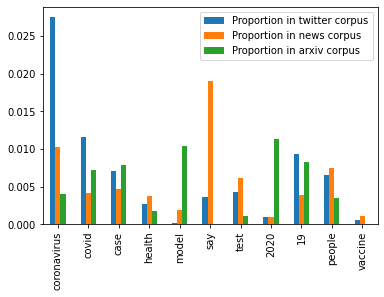

In [101]:
# this cell has been taggged with excluded_from_script
# it will not be run by the autograder
def get_word_frequency_across_corpuses(words):
    twitter_corpus, news_corpus, arxiv_corpus = get_corpuses()
    twitter_corpus_size = sum(len(d) for d in twitter_corpus)
    news_corpus_size = sum(len(d) for d in news_corpus)
    arxiv_corpus_size = sum(len(d) for d in arxiv_corpus)
    twitter_f, news_f, arxiv_f = word_frequency(twitter_corpus), word_frequency(news_corpus), word_frequency(arxiv_corpus)
    return pd.DataFrame({
        "Proportion in twitter corpus" : [twitter_f.get(word, 0) / twitter_corpus_size for word in words],
        "Proportion in news corpus" : [news_f.get(word, 0) / news_corpus_size for word in words],
        "Proportion in arxiv corpus" : [arxiv_f.get(word, 0) / arxiv_corpus_size for word in words]
    }, index = words)

df_frequency = get_word_frequency_across_corpuses([
    "coronavirus", "covid", "case", "health", "model", "say", "test",
    "2020", "19", "people", "vaccine"
])

display(df_frequency)

df_frequency.plot(kind='bar')

We see that there are differences across datasets in the relative frequency of each term. "Coronavirus" is used most frequently in tweets, "say" most frequently in news corpus, and perhaps unsurprisingly, "model" most frequently in arxiv papers. The scientific notation of coronavirus, "covid," isn't used in news articles as much, but is equally popular in both tweets and arxiv papers. On the other hand, "health" sees most frequent usage in news articles, likely due to health advice-related articles. Feel free to edit the word list above and see what other insights you can derive!

We now move to the last step of data collection and preparation: constructing input features to be used for more formal analyses and language modeling. As language modeling will be covered later in the course, here we will only cover two simple feature construction methods: term frequency (TF) and term frequency - inverse document frequency (TF-IDF).

### Question 13: Feature construction: term frequency (TF)
Implement the function `construct_tf_matrix` that takes as input a corpus and outputs a matrix $TF$ where each row corresponds to one document, and each column corresponds to one of the unique words in the entire corpus. $TF_{ij}$ is the number of times word $j$ appears in document $i$. Similar to the previous question, rare words that only appear once in the entire corpus should be removed, i.e., there should be no columns for those words.

**Notes**:
* The rows should be ordered based on the document ordering in the corpus. Row 0 corresponds to `corpus[0]`, row 1 to `corpus[1]`, and so on.
* The columns should be ordered based on the alphebatical order of their corresponding words. Column 0 corresponds to the alphabetically first word in the corpus, column 1 to the alphabetically second word, and so on.
* To ensure code efficiency, avoid using too many for-loops; take advantage of Pandas and Numpy functionalities.

In [41]:
def compute_TF_doc(doc, columns):
      full_count = collections.Counter(doc)
      return [full_count[x] for x in columns]

corpus = [
        "this project is project 3 in foundations of computational data science".split(),
        "it covers text data collection and preparation in the data science pipeline".split(),
        "text processing can be tricky sometimes".split()
    ]
col_sort = [x[0] for x in sorted(word_frequency(corpus).items())] # sort by key (word alphbetically)

values = list(map(lambda doc, columns=col_sort: compute_TF_doc(doc,col_sort), corpus))
df_matrix = pd.DataFrame(values, index=sorted(list(range(len(corpus)))), columns=col_sort)
df_matrix.to_numpy()

array([[1, 1, 2, 1, 0],
       [2, 1, 0, 1, 1],
       [0, 0, 0, 0, 1]])

In [42]:
def construct_tf_matrix(corpus):
    """
    Construct a term frequency matrix from an input corpus
    
    args:
        corpus (List[List[str]]) : a nested list of word tokens, where each inner list is a document
    
    return:
        np.array[n_documents, n_words] : the term frequency matrix
    """
    def compute_TF_doc(doc, columns):
      full_count = collections.Counter(doc)
      return [full_count[x] for x in columns]
    
    # Remove low freq words and sort by key (word alphbetically)
    col_sort = [x[0] for x in sorted(word_frequency(corpus).items())]
    values = list(map(lambda doc, columns=col_sort: compute_TF_doc(doc, col_sort), corpus))
    df_matrix = pd.DataFrame(values, index=sorted(list(range(len(corpus)))), columns=col_sort)
    return df_matrix.to_numpy()

In [44]:
def test_construct_tf_matrix():
    corpus = [
        "this project is project 3 in foundations of computational data science".split(),
        "it covers text data collection and preparation in the data science pipeline".split(),
        "text processing can be tricky sometimes".split()
    ]
    tf = construct_tf_matrix(corpus)
    assert (tf == np.array([
        [1, 1, 2, 1, 0],
        [2, 1, 0, 1, 1],
        [0, 0, 0, 0, 1]]
    )).all()
    
    twitter_corpus, news_corpus, arxiv_corpus = get_corpuses()
    all_corpuses = twitter_corpus + news_corpus + arxiv_corpus
    tf = construct_tf_matrix(all_corpuses)
    assert tf.dtype == np.int64
    assert tf.shape == (10025, 10011)
    assert (tf.sum(axis = 1)[:10] == np.array([ 9, 14, 10, 17, 27,  4, 22, 23, 17, 13])).all()
    assert (tf.sum(axis = 1)[-10:] == np.array([1465, 1935, 4683, 1857, 2096, 2498, 1995, 2324, 1811, 3370])).all()
    print("All tests passed!")

test_construct_tf_matrix()

All tests passed!
CPU times: user 1min 10s, sys: 659 ms, total: 1min 11s
Wall time: 1min 12s


### Question 14: Feature construction: term frequency - inverse document frequency (TF-IDF)
We can now compute the TF-IDF matrix, which scales the columns of the term frequency matrix by their inverse document frequency. Recall that the inverse document frequency of a word $j$ is computed as
$$\text{IDF}_j = \log \left( \frac{\# \text{of documents}}{\# \text{of documents with word } j} \right),$$
and so the $\text{TF-IDF}_{ij}$ entry in the tf-idf matrix is computed as
$$\text{TF-IDF}_{ij} = \text{TF}_{ij} \times \text{IDF}_j.$$

Implement the function `tf_idf_matrix` which takes as input a TF matrix and outputs the corresponding TF-IDF matrix.

In [52]:
def construct_tf_idf_matrix(tf_matrix):
    """
    Compute the term frequency - inverse document frequency in a corpus
    
    args:
        tf_matrix (np.array[n_documents, n_words]) : the term frequency document of the corpus
    
    return:
        np.array[n_documents, n_words] : the tf-idf matrix
    """
    num_documents = tf_matrix.shape[0]
    idf_matrix = np.vstack([np.log(num_documents / tf_matrix.astype(bool).sum(axis=0))] * num_documents)
    return np.multiply(tf_matrix, idf_matrix)

In [53]:
def test_construct_tf_idf_matrix():
    corpus = [
        "this project is project 3 in foundations of computational data science".split(),
        "it covers text data collection and preparation in the data science pipeline".split(),
        "text processing can be tricky sometimes".split()
    ]
    tf_idf = construct_tf_idf_matrix(construct_tf_matrix(corpus))
    assert np.allclose(tf_idf, np.array([
        [0.40546511, 0.40546511, 2.19722458, 0.40546511, 0.        ],
        [0.81093022, 0.40546511, 0.        , 0.40546511, 0.40546511],
        [0.        , 0.        , 0.        , 0.        , 0.40546511]
    ]))
    print("All tests passed!")
    
test_construct_tf_idf_matrix()

All tests passed!


# Do not run or modify the code below

In [ ]:
import pickle
import os.path

# q1
def grader_test_preprocess_text():
    text = open("q1_preprocess_text_inputs.txt", "r").read()
    result = preprocess_text(text, english_stopwords)
    print(result)
    
    
# q2
def grader_test_get_tweets():
    _, result = get_tweets()
    print(result)


# q3
def grader_test_get_tweet_texts_with_params():
    lang, start, end, n = open("q3_get_tweet_texts_with_params_inputs.txt", "r").read().splitlines()
    result = get_tweet_texts_with_params(lang = lang, start = start, end = end, n_tweets = int(n))
    pd.to_pickle(result, "q3_get_tweet_texts_with_params.pkl")
    print(result)
    

# q4
def grader_test_process_tweet_data():
    tweet_texts = pd.read_pickle("q3_get_tweet_texts_with_params.pkl")
    result = process_tweet_data(tweet_texts)
    pd.to_pickle(result,'q4_process_tweet_data.pkl')
    print(result)
    
# q5
def grader_test_parse_page_nature():
    links = open("q5_parse_page_nature_inputs.txt", "r").read().split("\n")
    result = [parse_page_nature(link) for link in links]
    print(result)

    
# q6
def grader_test_extract_nature_articles():
    start_date, end_date = open("q6_extract_nature_articles_inputs.txt", "r").read().splitlines()
    result = extract_nature_articles(start_date, end_date)
    pd.to_pickle(result, 'q6_extract_nature_articles.pkl')
    print(result) 
    

# q7
def grader_test_parse_page_nyt():
    links = open("q7_parse_page_nyt_inputs.txt").read().splitlines()
    result = [parse_page_nyt(link) for link in links]
    print(result)


# q8
def grader_test_extract_nyt_articles():
    start_date, end_date = open("q8_extract_nyt_articles_inputs.txt", "r").read().splitlines()
    result = extract_nyt_articles(start_date, end_date)
    pd.to_pickle(result, 'q8_extract_nyt_articles.pkl')
    print(result)     
    
# q9
def grader_test_process_news_articles_data():
    articles = pd.read_pickle('q6_extract_nature_articles.pkl')
    result = process_news_articles_data(articles)
    pd.to_pickle(result, 'q9_process_news_articles_data.pkl')
    print(result)         
    

# q10
def grader_test_parse_and_clean_pdf():
    result = parse_and_clean_pdf("pdfs/arxiv_11.pdf")
    print(result)      
    

# q11
def grader_test_process_arxiv_data():
    result = process_arxiv_data("pdfs")
    pd.to_pickle(result, 'q11_process_arxiv_data.pkl')
    result = sorted(sum(result, []))
    print(result) 
    
# q12
def grader_test_word_frequency():
    tweet_corpus = pd.read_pickle('q4_process_tweet_data.pkl')
    result = word_frequency(tweet_corpus)
    print(result)
    
# q13
def grader_test_construct_tf_matrix():
    all_corpuses = (
        pd.read_pickle("q4_process_tweet_data.pkl"),
        pd.read_pickle('q9_process_news_articles_data.pkl'),
        pd.read_pickle('q11_process_arxiv_data.pkl')
    )
    result = construct_tf_matrix(all_corpuses[0] + all_corpuses[1] + all_corpuses[2])
    np.savetxt("q13_construct_tf_matrix.npy", result, fmt = "%d")
    print(result)
    
# q14
def grader_test_construct_tf_idf_matrix():
    tf_matrix = np.loadtxt("q13_construct_tf_matrix.npy", dtype = np.int64)
    result = construct_tf_idf_matrix(tf_matrix)
    print(result.round(10))


In [ ]:
def main():
    global PATH_TO_CHROMEDRIVER
    global PATH_TO_GECKODRIVER
    PATH_TO_CHROMEDRIVER = "/usr/bin/chromedriver"
    PATH_TO_GECKODRIVER = "/usr/bin/geckodriver"
    # set description
    parser = argparse.ArgumentParser(description="Data Preparation")
    parser.add_argument("-r",
                        metavar='<question_id>',
                        required=False)
    args = parser.parse_args()
    question = args.r

    if question is None:
        grader_test_preprocess_text()
        grader_test_get_tweets()
        grader_test_get_tweet_texts_with_params()
        grader_test_process_tweet_data()
        grader_test_parse_page_nature()
        grader_test_extract_nature_articles()
        grader_test_parse_page_nyt()
        grader_test_extract_nyt_articles()
        grader_test_process_news_articles_data()
        grader_test_parse_and_clean_pdf()
        grader_test_process_arxiv_data()
        grader_test_word_frequency()
        grader_test_construct_tf_matrix()
        grader_test_construct_tf_idf_matrix()
    elif question == "q1":
        grader_test_preprocess_text()
    elif question == "q2":
        grader_test_get_tweets()
    elif question == "q3":
        grader_test_get_tweet_texts_with_params()
    elif question == "q4":
        grader_test_process_tweet_data()
    elif question == "q5":
        grader_test_parse_page_nature()
    elif question == "q6":
        grader_test_extract_nature_articles()
    elif question == "q7":
        grader_test_parse_page_nyt()
    elif question == "q8":
        grader_test_extract_nyt_articles()
    elif question == "q9":
        grader_test_process_news_articles_data()
    elif question == "q10":
        grader_test_parse_and_clean_pdf()
    elif question == "q11":
        grader_test_process_arxiv_data()  
    elif question == "q12":
        grader_test_word_frequency()
    elif question == "q13":
        grader_test_construct_tf_matrix()
    elif question == "q14":
        grader_test_construct_tf_idf_matrix()
    else:
        print("Invalid question")
        
if __name__ == "__main__":
    main()